# Desafío - Mecanismos de Votación
___

Nombre: __Hugo Zúñiga__

Profesor: Josué Fredes

Generación: __G4__

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad. 
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y `csv`). 
* Una vez terminado el desafío, comprime la carpeta y sube el `.zip` a la sección correspondiente.

## Descripción

Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o inpopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.. Los artículos registrados son de la página web www.mashable.com.

Más información sobre los atributos se puede encontrar en el archivo `OnlineNewsPopularity.names`.

## Ejercicio 1 - Preparación del Ambiente de Trabajo

* A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función grid_plot_batch que se encuentra en el archivo `helpers.py`.

```python
# las etiquetas de las columnas presentan un espacio extra, con ésto lo
podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"),
axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
```

* Describa el comportamiento de las variables.
* Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función `identify_high_correlations` que se encuentra en el archivo `helpers.py`. Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
* Antes de generar los conjuntos de entrenamiento y validación, preprocese los datos con los siguientes pasos:
    * Recodifique la variable `shares` en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable `shares` posteriormente.
    * Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    * Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [1]:
# Importo las librerias base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importo las librerias necesarias
import helpers as h
import re
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# Estilo gráficos
#plt.style.use('seaborn')

# Defino la semilla pseudoaleatoria
rep_seed = 16254

In [2]:
# importo la data
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')

In [3]:
df.shape

(39644, 61)

In [4]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

In [5]:
# Reviso la naturaleza de las variables
qnty.describe()

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
count    39644.000000      39644.000000     39644.000000      39644.000000   
mean        10.398749        546.514731         0.548216          0.996469   
std          2.114037        471.107508         3.520708          5.231231   
min          2.000000          0.000000         0.000000          0.000000   
25%          9.000000        246.000000         0.470870          1.000000   
50%         10.000000        409.000000         0.539226          1.000000   
75%         12.000000        716.000000         0.608696          1.000000   
max         23.000000       8474.000000       701.000000       1042.000000   

       n_non_stop_unique_tokens  
count              39644.000000  
mean                   0.689175  
std                    3.264816  
min                    0.000000  
25%                    0.625739  
50%                    0.690476  
75%                    0.754630  
max                  650.000000

In [6]:
# Reviso el volumen de datos
qnty.shape

(39644, 5)

In [7]:
# Reviso los tipos de datos
qnty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 5 columns):
n_tokens_title              39644 non-null float64
n_tokens_content            39644 non-null float64
n_unique_tokens             39644 non-null float64
n_non_stop_words            39644 non-null float64
n_non_stop_unique_tokens    39644 non-null float64
dtypes: float64(5)
memory usage: 1.5 MB


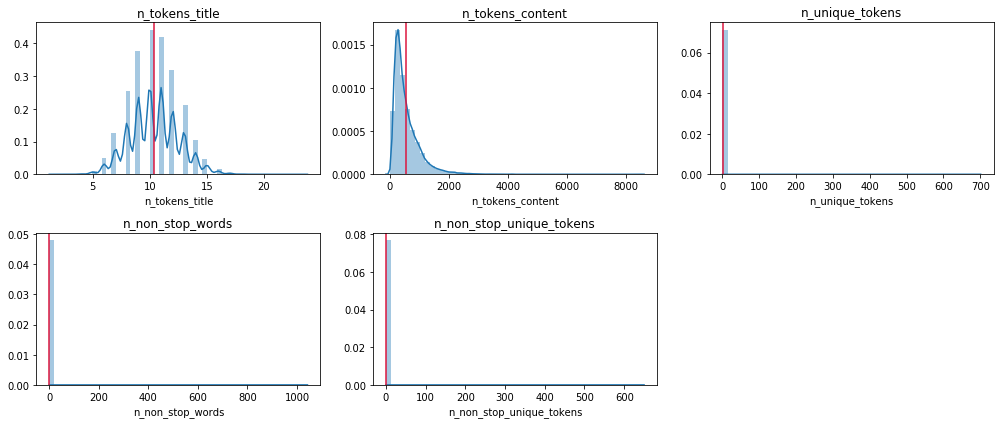

In [8]:
plt.figure(figsize=(14,6))
h.plot_describe_variables(qnty.dropna(), 3)

__Comentarios:__ Se ve que estas variables corresponden a cantidades donde además hay un alto sesgo en la mayoría.

In [9]:
# Reviso la naturaleza de las variables
channel.describe()

data_channel_is_lifestyle  data_channel_is_entertainment  \
count               39644.000000                   39644.000000   
mean                    0.052946                       0.178009   
std                     0.223929                       0.382525   
min                     0.000000                       0.000000   
25%                     0.000000                       0.000000   
50%                     0.000000                       0.000000   
75%                     0.000000                       0.000000   
max                     1.000000                       1.000000   

       data_channel_is_bus  data_channel_is_socmed  data_channel_is_tech  \
count         39644.000000            39644.000000          39644.000000   
mean              0.157855                0.058597              0.185299   
std               0.364610                0.234871              0.388545   
min               0.000000                0.000000              0.000000   
25%               0.000000                0.000000              0.000000   
50%               0.000000                0.000000              0.000000   
75%               0.000000                0.000000              0.000000   
max               1.000000                1.000000              1.000000   

       data_channel_is_world  
count           39644.000000  
mean                0.212567  
std                 0.409129  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [10]:
# Reviso los tipo de datos
channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 6 columns):
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null float64
data_channel_is_socmed           39644 non-null float64
data_channel_is_tech             39644 non-null float64
data_channel_is_world            39644 non-null float64
dtypes: float64(6)
memory usage: 1.8 MB


In [11]:
# Reviso el volumen
channel.shape

(39644, 6)

In [12]:
plt.figure(figsize=(14,6))
h.plot_describe_variables(channel.dropna(), 3)

__Comentarios:__ Se ve que estas variables son binarias y representan el tipo de contenido del sitio web.

In [13]:
# reviso la naturaleza de las variables
days.describe()

weekday_is_monday  weekday_is_tuesday  weekday_is_wednesday  \
count       39644.000000        39644.000000          39644.000000   
mean            0.168020            0.186409              0.187544   
std             0.373889            0.389441              0.390353   
min             0.000000            0.000000              0.000000   
25%             0.000000            0.000000              0.000000   
50%             0.000000            0.000000              0.000000   
75%             0.000000            0.000000              0.000000   
max             1.000000            1.000000              1.000000   

       weekday_is_thursday  weekday_is_friday  weekday_is_saturday  \
count         39644.000000       39644.000000         39644.000000   
mean              0.183306           0.143805             0.061876   
std               0.386922           0.350896             0.240933   
min               0.000000           0.000000             0.000000   
25%               0.000000           0.000000             0.000000   
50%               0.000000           0.000000             0.000000   
75%               0.000000           0.000000             0.000000   
max               1.000000           1.000000             1.000000   

       weekday_is_sunday    is_weekend  
count       39644.000000  39644.000000  
mean            0.069039      0.130915  
std             0.253524      0.337312  
min             0.000000      0.000000  
25%             0.000000      0.000000  
50%             0.000000      0.000000  
75%             0.000000      0.000000  
max             1.000000      1.000000

In [14]:
# Reviso el tipo de dato
days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 8 columns):
weekday_is_monday       39644 non-null float64
weekday_is_tuesday      39644 non-null float64
weekday_is_wednesday    39644 non-null float64
weekday_is_thursday     39644 non-null float64
weekday_is_friday       39644 non-null float64
weekday_is_saturday     39644 non-null float64
weekday_is_sunday       39644 non-null float64
is_weekend              39644 non-null float64
dtypes: float64(8)
memory usage: 2.4 MB


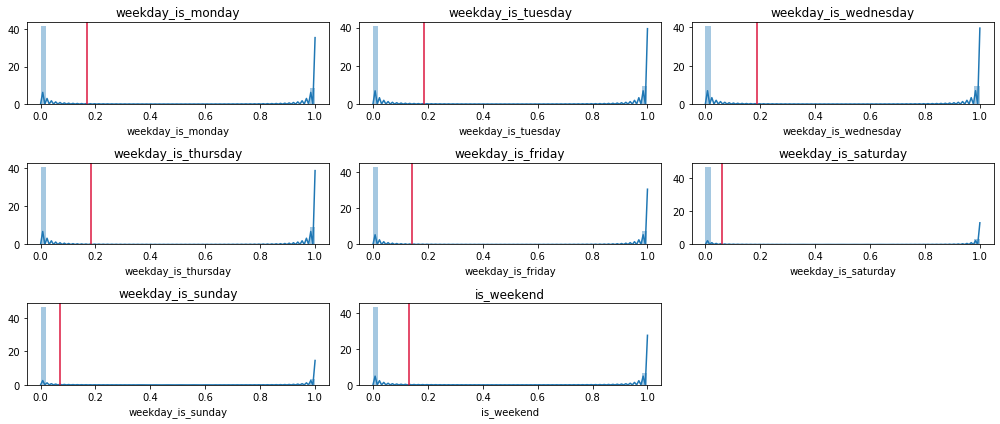

In [15]:
plt.figure(figsize=(14,6))
h.plot_describe_variables(days.dropna(), 3)

__Comentarios:__ Al igual que la anterior, estas variables son binarias e indican si pertenecen a los días de la semana o fin de semana.

In [16]:
# Reviso la naturaleza de las variables
sentiments.describe()

global_subjectivity  global_rate_positive_words  \
count         39644.000000                39644.000000   
mean              0.443370                    0.039625   
std               0.116685                    0.017429   
min               0.000000                    0.000000   
25%               0.396167                    0.028384   
50%               0.453457                    0.039023   
75%               0.508333                    0.050279   
max               1.000000                    0.155488   

       global_rate_negative_words  rate_positive_words  rate_negative_words  \
count                39644.000000         39644.000000         39644.000000   
mean                     0.016612             0.682150             0.287934   
std                      0.010828             0.190206             0.156156   
min                      0.000000             0.000000             0.000000   
25%                      0.009615             0.600000             0.185185   
50%                      0.015337             0.710526             0.280000   
75%                      0.021739             0.800000             0.384615   
max                      0.184932             1.000000             1.000000   

       avg_positive_polarity  min_positive_polarity  max_positive_polarity  \
count           39644.000000           39644.000000           39644.000000   
mean                0.353825               0.095446               0.756728   
std                 0.104542               0.071315               0.247786   
min                 0.000000               0.000000               0.000000   
25%                 0.306244               0.050000               0.600000   
50%                 0.358755               0.100000               0.800000   
75%                 0.411428               0.100000               1.000000   
max                 1.000000               1.000000               1.000000   

       avg_negative_polarity  min_negative_polarity  max_negative_polarity  \
count           39644.000000           39644.000000           39644.000000   
mean               -0.259524              -0.521944              -0.107500   
std                 0.127726               0.290290               0.095373   
min                -1.000000              -1.000000              -1.000000   
25%                -0.328383              -0.700000              -0.125000   
50%                -0.253333              -0.500000              -0.100000   
75%                -0.186905              -0.300000              -0.050000   
max                 0.000000               0.000000               0.000000   

       title_subjectivity  abs_title_subjectivity  
count        39644.000000            39644.000000  
mean             0.282353                0.341843  
std              0.324247                0.188791  
min              0.000000                0.000000  
25%              0.000000                0.166667  
50%              0.150000                0.500000  
75%              0.500000                0.500000  
max              1.000000                0.500000

In [17]:
# reviso los tipos de datos
sentiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 13 columns):
global_subjectivity           39644 non-null float64
global_rate_positive_words    39644 non-null float64
global_rate_negative_words    39644 non-null float64
rate_positive_words           39644 non-null float64
rate_negative_words           39644 non-null float64
avg_positive_polarity         39644 non-null float64
min_positive_polarity         39644 non-null float64
max_positive_polarity         39644 non-null float64
avg_negative_polarity         39644 non-null float64
min_negative_polarity         39644 non-null float64
max_negative_polarity         39644 non-null float64
title_subjectivity            39644 non-null float64
abs_title_subjectivity        39644 non-null float64
dtypes: float64(13)
memory usage: 3.9 MB


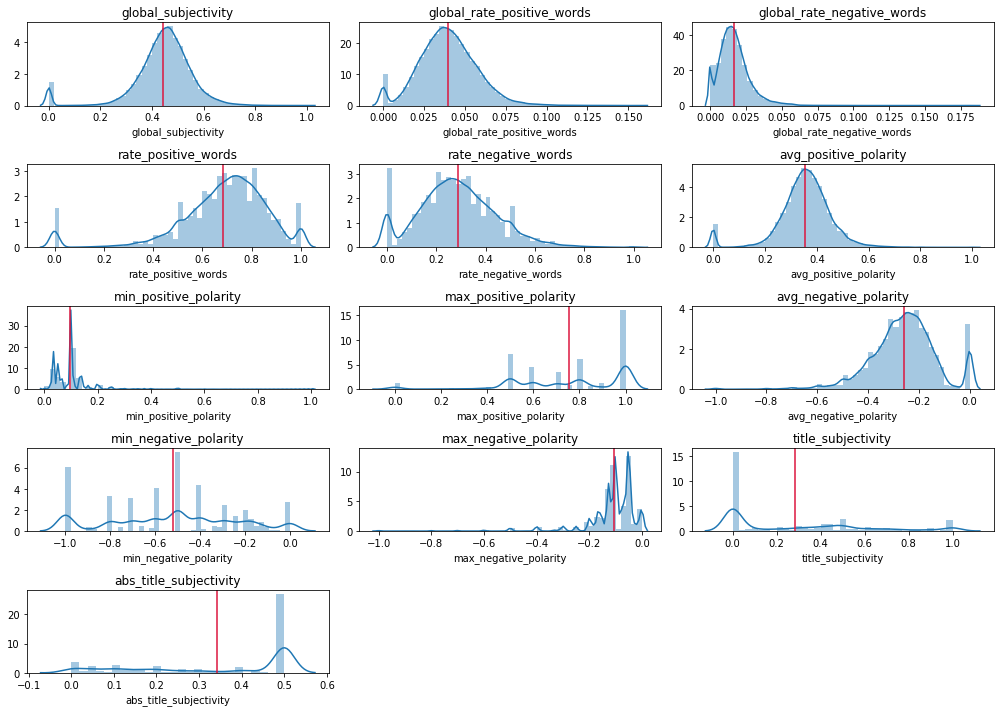

In [18]:
plt.figure(figsize=(14,10))
h.plot_describe_variables(sentiments.dropna(), 3)

__Comentarios:__ Estas son variables continuas que hacen referencia al comportamiento de la popularidad del sitio.

In [19]:
# Reviso la naturaleza de estas variables
lda.describe()

LDA_00        LDA_01        LDA_02        LDA_03        LDA_04
count  39644.000000  39644.000000  39644.000000  39644.000000  39644.000000
mean       0.184599      0.141256      0.216321      0.223770      0.234029
std        0.262975      0.219707      0.282145      0.295191      0.289183
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.025051      0.025012      0.028571      0.028571      0.028574
50%        0.033387      0.033345      0.040004      0.040001      0.040727
75%        0.240958      0.150831      0.334218      0.375763      0.399986
max        0.926994      0.925947      0.919999      0.926534      0.927191

In [20]:
# reviso los tipos de datos
lda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 5 columns):
LDA_00    39644 non-null float64
LDA_01    39644 non-null float64
LDA_02    39644 non-null float64
LDA_03    39644 non-null float64
LDA_04    39644 non-null float64
dtypes: float64(5)
memory usage: 1.5 MB


In [21]:
plt.figure(figsize=(14,8))
h.plot_describe_variables(lda.dropna(), 3)

__Comentarios:__ Estas variables presentan un alto sesgo.

In [22]:
# reviso la naturaleza de las variables
keywords.describe()

kw_min_min     kw_max_min    kw_avg_min     kw_min_max  \
count  39644.000000   39644.000000  39644.000000   39644.000000   
mean      26.106801    1153.951682    312.366967   13612.354102   
std       69.633215    3857.990877    620.783887   57986.029357   
min       -1.000000       0.000000     -1.000000       0.000000   
25%       -1.000000     445.000000    141.750000       0.000000   
50%       -1.000000     660.000000    235.500000    1400.000000   
75%        4.000000    1000.000000    357.000000    7900.000000   
max      377.000000  298400.000000  42827.857143  843300.000000   

          kw_max_max     kw_avg_max    kw_min_avg     kw_max_avg    kw_avg_avg  
count   39644.000000   39644.000000  39644.000000   39644.000000  39644.000000  
mean   752324.066694  259281.938083   1117.146610    5657.211151   3135.858639  
std    214502.129573  135102.247285   1137.456951    6098.871957   1318.150397  
min         0.000000       0.000000     -1.000000       0.000000      0.000000  
25%    843300.000000  172846.875000      0.000000    3562.101631   2382.448566  
50%    843300.000000  244572.222223   1023.635611    4355.688836   2870.074878  
75%    843300.000000  330980.000000   2056.781032    6019.953968   3600.229564  
max    843300.000000  843300.000000   3613.039820  298400.000000  43567.659946

In [23]:
# reviso los tipos de datos
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 9 columns):
kw_min_min    39644 non-null float64
kw_max_min    39644 non-null float64
kw_avg_min    39644 non-null float64
kw_min_max    39644 non-null float64
kw_max_max    39644 non-null float64
kw_avg_max    39644 non-null float64
kw_min_avg    39644 non-null float64
kw_max_avg    39644 non-null float64
kw_avg_avg    39644 non-null float64
dtypes: float64(9)
memory usage: 2.7 MB


In [24]:
plt.figure(figsize=(14,8))
h.plot_describe_variables(keywords.dropna(), 3)

__Comentarios:__ Nuevamente nos encontramos con variables continuas con alto sesgo.

In [25]:
# Analizo la correlación entre variables
corr = h.identify_high_correlations(df, .8)
corr

variable                       var2     value
179             n_non_stop_words            n_unique_tokens  0.999572
238     n_non_stop_unique_tokens            n_unique_tokens  0.999852
239     n_non_stop_unique_tokens           n_non_stop_words  0.999532
1139                  kw_avg_min                 kw_max_min  0.940529
1256                  kw_max_max                 kw_min_min -0.857226
1499                  kw_avg_avg                 kw_max_avg  0.811864
1678  self_reference_avg_sharess  self_reference_min_shares  0.818907
1679  self_reference_avg_sharess  self_reference_max_shares  0.853480
2317                      LDA_02      data_channel_is_world  0.836618

In [26]:
# Recodifico la variable shares
df['shares'] = np.where(df['shares'] > 1400, 1, 0)
df['shares'].value_counts()

0    20082
1    19562
Name: shares, dtype: int64

In [27]:
# Genero una lista con los nombres de las columnas a borrar
lista1 = list(corr.loc[:,'variable'])
lista2 = list(corr.loc[:,'var2'])
lista = lista1 + lista2
lista

['n_non_stop_words',
 'n_non_stop_unique_tokens',
 'n_non_stop_unique_tokens',
 'kw_avg_min',
 'kw_max_max',
 'kw_avg_avg',
 'self_reference_avg_sharess',
 'self_reference_avg_sharess',
 'LDA_02',
 'n_unique_tokens',
 'n_unique_tokens',
 'n_non_stop_words',
 'kw_max_min',
 'kw_min_min',
 'kw_max_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'data_channel_is_world']

In [28]:
# Elimino las columnas de la lista, que representan los atributos con correlación mayor a .8
final_df = df.drop(columns=lista, axis=1)
final_df.shape

(39644, 45)

In [29]:
final_df.columns

Index(['n_tokens_title', 'n_tokens_content', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'weekday_is_monday',
       'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
       'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subje

In [30]:
# Aplicaremos standarscaler antes de PCA
variables = list(final_df.drop(columns=['shares']).columns)
x = final_df.loc[:, variables].values
x_std = StandardScaler().fit_transform(x)
new_df = pd.DataFrame(data = x_std, columns = variables)
new_df.head()

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
0        0.757447         -0.695210  -0.607463       -0.335566 -0.426526   
1       -0.661657         -0.618794  -0.695709       -0.594963 -0.426526   
2       -0.661657         -0.712192  -0.695709       -0.594963 -0.426526   
3       -0.661657         -0.032933  -0.166229       -0.854360 -0.426526   
4        1.230482          1.115439   0.716237        4.074185  1.860061   

   num_videos  average_token_length  num_keywords  data_channel_is_lifestyle  \
0   -0.304268              0.156474     -1.164821                  -0.236445   
1   -0.304268              0.432838     -1.688626                  -0.236445   
2   -0.304268             -0.183415     -0.641015                  -0.236445   
3   -0.304268             -0.169758     -0.117210                  -0.236445   
4   -0.304268              0.159400     -0.117210                  -0.236445   

   data_channel_is_entertainment  ...  avg_positive_polarity  \
0                       2.148880  ...               0.237337   
1                      -0.465359  ...              -0.640040   
2                      -0.465359  ...               1.358401   
3                       2.148880  ...               0.307442   
4                      -0.465359  ...               0.548135   

   min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
0               0.063865              -0.228941              -0.708369   
1              -0.870968              -0.228941               1.102174   
2               0.063865               0.981798              -1.621797   
3               0.573773               0.174639              -0.862584   
4              -0.870968               0.981798               0.307944   

   min_negative_polarity  max_negative_polarity  title_subjectivity  \
0              -0.268895              -0.969886            0.671245   
1               1.367424               0.078642           -0.870807   
2              -0.957871              -0.270867           -0.870807   
3              -0.268895              -0.620377           -0.870807   
4               0.075594               0.602906            0.531059   

   title_sentiment_polarity  abs_title_subjectivity  \
0                 -0.975432               -1.810719   
1                 -0.269076                0.837749   
2                 -0.269076                0.837749   
3                 -0.269076                0.837749   
4                  0.244637               -1.569949   

   abs_title_sentiment_polarity  
0                      0.138920  
1                     -0.689658  
2                     -0.689658  
3                     -0.689658  
4                     -0.087056  

[5 rows x 44 columns]

In [31]:
# Aplicamos PCA para identificar las principales 30 dimensiones
pca = PCA(n_components=30)
pca_fit = pca.fit_transform(x_std)

In [32]:
pca_fit.shape

(39644, 30)

In [33]:
print("La varianza explicada de cada dimensión es de:", pca.explained_variance_ratio_)
print("\nEn conjunto, ambas dimensiones explican la varianza en un: ", sum(pca.explained_variance_ratio_))

La varianza explicada de cada dimensión es de: [0.10552208 0.08602823 0.06147981 0.05766724 0.04971791 0.04545988
 0.04451544 0.04200949 0.03306466 0.03127279 0.02807231 0.02794126
 0.02766343 0.02716547 0.0267719  0.02621381 0.0253676  0.02403627
 0.02108478 0.0195787  0.01847988 0.01631536 0.0155749  0.01513438
 0.01427652 0.0133808  0.0123895  0.01095726 0.01045133 0.0102216 ]

En conjunto, ambas dimensiones explican la varianza en un:  0.9478145981861411


In [34]:
# Genero una lista con los nombres de los componentes
componentes = []
for i in range(pca_fit.shape[1]):
    componentes.append('componente_'+str(i+1))

In [35]:
# Genero un dataframe con los componentes
df_pca = pd.DataFrame(pca_fit, columns=componentes)
df_pca.head()

componente_1  componente_2  componente_3  componente_4  componente_5  \
0     -0.609857      0.388802      0.900434     -0.240299     -1.833939   
1      1.389403     -2.000910      0.381147     -3.072095      0.940077   
2     -2.794300     -2.092927     -0.471185     -2.506017     -0.853098   
3     -0.293153      1.050763     -1.043304     -0.782225     -1.621897   
4     -3.217872     -2.736586     -2.327904      2.334267      0.878220   

   componente_6  componente_7  componente_8  componente_9  componente_10  ...  \
0     -0.208244     -0.230784     -2.988238      1.334300       0.693037  ...   
1     -0.340678     -0.639871     -2.139515     -0.088195      -0.952283  ...   
2      0.438603     -0.269636     -0.960044      0.041460       0.440156  ...   
3      0.567288      1.399221     -2.637609      0.588000      -0.023676  ...   
4     -2.570020      0.528315      0.558675      1.594646       0.211810  ...   

   componente_21  componente_22  componente_23  componente_24  componente_25  \
0       0.919369       0.811418       0.426682      -0.571154       0.854608   
1      -0.100439       0.495433      -0.637160      -0.721398       0.643771   
2      -0.680275      -0.429567       0.963545      -0.596710       0.078765   
3      -0.748097       0.049719       0.397017       0.298841       0.158353   
4       1.342929      -0.664875      -0.533909      -0.729256       0.939585   

   componente_26  componente_27  componente_28  componente_29  componente_30  
0       0.161487       0.409046      -0.967576      -0.137002       1.295045  
1       1.016606      -0.558936      -1.259379       0.762058       0.744027  
2       0.552731       0.541911      -0.203318      -0.364759       1.257699  
3      -0.052111       0.201565      -0.618439       0.157614       0.904361  
4       1.528373       1.045901      -0.752216      -0.190533      -0.020695  

[5 rows x 30 columns]

## Ejercicio 2 - Evaluación de modelos individuales

* A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    * Importe los módulos correctamente.
    * Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a `Precision`, `Recall`, `F1`. Puede hacer uso de la función `plot_classification_report` disponible en el archivo `helpers.py`.
    * Comente el desempeño general de cada uno.
* La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    * Regresión Logística.
    * Algoritmo de KMedias.
    * Árbol de Clasificación con un `max_depth = 1`.
    * Árbol de Clasificación con un `max_depth = 4`.

In [36]:
# Genero mi conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(df_pca,
                                                    final_df['shares'],
                                                    test_size=.33,
                                                    random_state=rep_seed)

In [37]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(26561, 30) (26561,)
(13083, 30) (13083,)


In [38]:
# Entreno modelo Regresión Logística
model_logit_reg = linear_model.LogisticRegression(solver = 'lbfgs')
model_logit_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# Genero el vector predicho
yhat_logit_reg = model_logit_reg.predict(X_test)

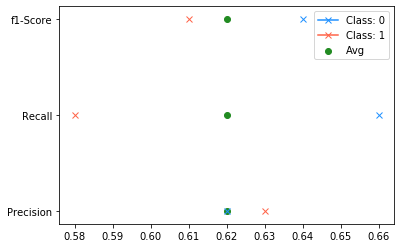

In [40]:
# Chequeo el desempeño
h.plot_classification_report(y_test, yhat_logit_reg)

Text(0.5, 1.0, 'Reducción de pérdida')

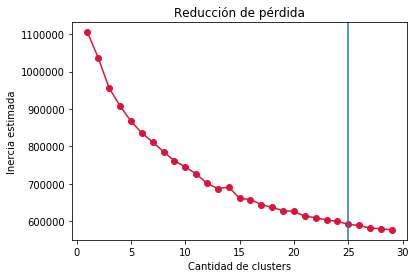

In [41]:
# Entreno modelo KMeans
# Verifico la cantidad de cluser a utilizar
cols = X_train.shape[1]
inercia = []

for i in range(1, cols):
    inercia.append(KMeans(n_clusters=i, random_state=rep_seed).fit(X_train).inertia_)

# Grafico el resultado
plt.plot(range(1, cols), inercia, 'o-', color='crimson')
plt.axvline(25)
plt.xlabel("Cantidad de clusters")
plt.ylabel("Inercia estimada")
plt.title("Reducción de pérdida")

In [42]:
# la inercia se estabiliza luego del punto 25, lo que nos indica que sería el número indicado de clusters

In [43]:
# entreno modelo kmeans con 25 cluster según lo indica el gráfico
kmeans = KMeans(n_clusters=25, random_state=rep_seed)
kmeans = kmeans.fit(X_train)

In [44]:
# el porcentaje de equistancia entre los centroides de cada etiqueta
pd.Series(kmeans.labels_).value_counts('%')

13    0.068785
9     0.067769
5     0.060578
20    0.059297
8     0.058582
6     0.058093
7     0.055570
2     0.054290
23    0.050977
22    0.049810
21    0.047890
18    0.043560
4     0.042054
16    0.041414
0     0.036068
12    0.033922
11    0.028613
3     0.028463
17    0.024961
15    0.020594
24    0.019465
1     0.015511
19    0.014834
10    0.013554
14    0.005346
dtype: float64

In [45]:
# chequeamos la inercia
kmeans.inertia_

591788.9163378885

In [46]:
# classification tree max deph = 1
class_tree_1 = DecisionTreeClassifier(max_depth=1, random_state=rep_seed)
class_tree_1_fit = class_tree_1.fit(X_train, y_train)
yhat_class_tree_1 = class_tree_1_fit.predict(X_test)

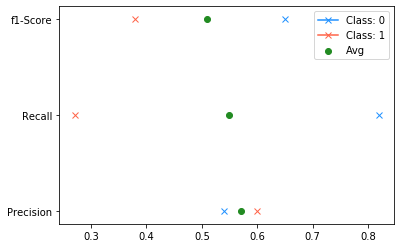

In [47]:
h.plot_classification_report(y_test, yhat_class_tree_1)

In [48]:
# classification tree max deph = 4
class_tree_4 = DecisionTreeClassifier(max_depth=4, random_state=rep_seed)
class_tree_4_fit = class_tree_4.fit(X_train, y_train)
yhat_class_tree_4 = class_tree_4_fit.predict(X_test)

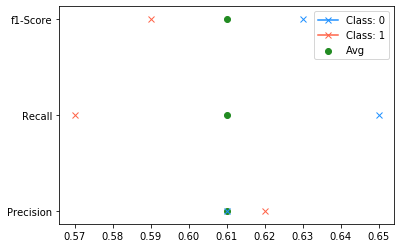

In [49]:
h.plot_classification_report(y_test, yhat_class_tree_4)

__Comentarios:__ Se ve que el mejor desempeño se encuentra en el árbol de decisión con máxima profundidad de 4 nodos. El árbol de decisión con máximo profundidad de 1 no tiene buen desempeño. El modelo de regresión logística tampoco presenta mal rendimiento.

## Ejercicio 3 - Entrenamiento de Comité

* Entrene el comité de clasificadores sin modificar el esquema de votación.
* Reporte el desempeño a nivel de cada clase para cada métrica.

In [50]:
# Defino el comité de clasificadores en una lista 
estimators = [('Logistic Regression', LogisticRegression(solver = 'lbfgs')),
              ('KMeans', KMeans(n_clusters=25, random_state=rep_seed)),
              ('Decision Tree Classifier 1', DecisionTreeClassifier(max_depth=1, random_state=rep_seed)),
              ('Decision Tree Classifier 4', DecisionTreeClassifier(max_depth=4, random_state=rep_seed)),
             ]

/Users/hugopriest/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


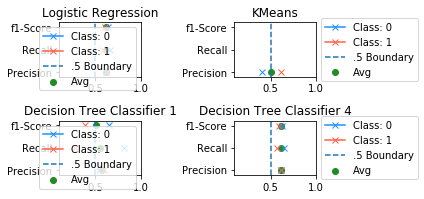

In [51]:
# Vemos el desempeño de cada clasificador
for index, value in enumerate(estimators):
    plt.subplot(3, 2, index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    plt.figure(figsize=(10))
    h.plot_classification_report(y_test, class_pred, dummy_class=True)
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

__Comentarios:__ En este caso el peor desempeño lo vemos en el árbol de decisión con max_deph = 1. El mejor desempeño se lo llega el modelo de regresión logística.

## Ejercicio 4 - Calibración de Comité con Ponderadores

* El base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
* Reporte el desempeño del mejor ensamble heterogéneo.

De acuerdo al comportamiento anterior los esquemas de ponderación son los siguientes:

* De mayor a menor peso: 'Logistic Regression', 'KMeans' (24 clusters), 'Decision Tree Classifier 4', 'Decission Tree Classifier 1'
* Mismo orden, pero eliminando 'Decision Tree Classifier 1'

In [52]:
# defino el comité de clasificadores de la primera estrategia
estimators = [('Logistic Regression', LogisticRegression(solver = 'lbfgs')),
              ('KMeans', KMeans(n_clusters=25, random_state=rep_seed)), 
              ('Decision Tree Classifier 1', DecisionTreeClassifier(max_depth=1, random_state=rep_seed)),
              ('Decision Tree Classifier 4', DecisionTreeClassifier(max_depth=4, random_state=rep_seed)),
             ]

In [53]:
# Entrenamos el clasificador 
vc_model = VotingClassifier(estimators, weights=[4,3,1,2]).fit(X_train, y_train)
# vector predicho
yhat_vc = vc_model.fit(X_train,y_train).predict(X_test)

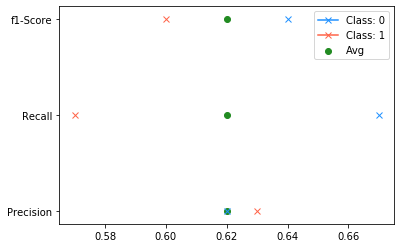

In [54]:
# Vemos el desempeño
h.plot_classification_report(y_test, yhat_vc)

In [55]:
# defino el comité de clasificadores de la segunda estrategia
estimators2 = [('Logistic Regression', LogisticRegression(solver = 'lbfgs')),
              ('KMeans', KMeans(n_clusters=25, random_state=rep_seed)), 
              ('Decision Tree Classifier 4', DecisionTreeClassifier(max_depth=4, random_state=rep_seed)),
             ]

In [56]:
# entreno el clasificador de la segunda estrategua
vc_model_2 = VotingClassifier(estimators2, weights=[4,2,1]).fit(X_train, y_train)
yhat_vc_2 = vc_model_2.fit(X_train,y_train).predict(X_test)

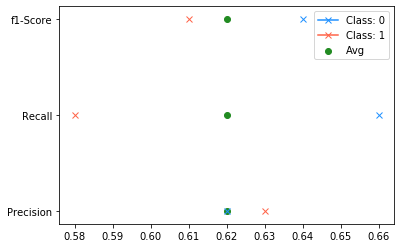

In [57]:
# Vemos el desempeño
h.plot_classification_report(y_test, yhat_vc_2)

__Comentarios:__ Vemos que la segunda estrategia nos entregó mejores resultados.